# Energy consumption of a Web Application Implemented in Different Programming Languages and Web Frameworks
*Probabilistic Programming 2025 Exam by Raúl Pardo ([raup@itu.dk](mailto:raup@itu.dk)) and Andrzej Wąsowski ([wasowski@itu.dk](mailto:wasowski@itu.dk))*<br/>
*version 1.0.0 2025-03-20 08:40*


In this exam, your task is to analyze energy consumption of different implementations of a web application.
The goal is to determine whether there are differences in energy consumption in different implementations of the web application or in its API endpoints.
This analysis is of utmost importance, as it might help software engineers to make informed choices that lower energy consumption. For instance, a plausible hypothesis is that lower level programming languages such as Rust consume less energy than higher level languages such as Python.
A preconception in this domain is that running time is the driving factor in energy consumption.
Are these true? The data in this exam and the analysis you will develop will allow to answer this type of questions.

## Data

The dataset contains $N = 1960$ measurements of energy consumption for different implementations and functionality of a web application. For each setup, there are 20 measurements. The dataset is in the file [dataset.csv](dataset.csv). The variables in the dataset are:

* **Application**. This variable has the form `<programming_language>-<web_framework>`. It specifies the programming language and web framework used in the experiment. For instance, `rust-actix` denotes the web framework Actix for the programming language Rust, or `c-sharp-razor` denotes the web framework Razor for the programming language C#.
    * Note that if a hypothesis involves only programming language, you need to extract it from the values in this variable.

* **Endpoint**. This variable refers to the API endpoints of the web application. For example, `/api/register` refers to the API endpoint used for registering users in the web application, or `/logout` is used for logging out of the system.

* **Runtime**. This variable indicates the time it took to process the request to the endpoint in seconds.

* **Energy consumption**. This variable indicates the energy consumed for processing the request to the endpoint in Joules.

Each row in the dataset is a measurement of the total energy consumed and runtime after processing a request in the corresponding API endpoint. The *Application* variable in each row indicates the web framework used for the measurement.

## Hypotheses

To analyze energy consumption in the different implementations, you must investigate the following hypotheses:

* **H1** - The web framework `c-sharp-razor` consumes more energy than any other web framework in the dataset.

* **H2** - The programming language `javascript` consumes the least amount of energy compared to any other programming language in the dataset.

* **H3** - Runtime has a stronger impact on energy consumption for some API endpoints than others. That is, the effect of runtime on energy consumption is larger for some API endpoints than others.

Your task is to use Bayesian Inference and Regression to decide whether these hypotheses hold, or possibly reject them. This includes:

* Loading, restructuring and transforming the data as needed.

* Designing Bayesian regression models and using inference algorithms to test the above hypotheses in PyMC.

* Explaining your model idea in English, preferably using a figure, and showing the Python code.

* Checking and reflecting (in writing) on the quality of the sampling process, considering warnings from the tool, sampling summary statistics, trace plots, and autocorrelation plots. Comment whether the quality of the sampled trace is good, and whether you had to make any adjustments during modeling and/or sampling.

* Visualizing the posterior information appropriately to address the hypotheses.
  

You should hand in a zip file with a Jupyter notebook and the data file (so that we can run it), and a **PDF file rendering of the Jupyter notebook**, so that your work can be assessed just by reading this file. It appears that the best PDF rendering is obtained by File / Export to HTML, and then saving/printing to PDF from your browser.

Make sure the notebook is actually a **report** readable to the examiners, especially to the censor who has not followed the course. The report should include:
* A brief introduction.
* Explanations on how data is loaded and cleaned.
* Explanations on analysis and model design (for each of the models you consider).
* A discussion of sampling quality (for each model) and all the plots that you present, and a reflection/decision on the outcome for each hypothesis.
* An overall conclusion.

**IMPORTANT:** For the tasks below, your code must accompany an explanation of its meaning and intended purpose. **Source code alone is not self-explanatory**. As mentioned above, you should also reflect on the results you get, e.g., highlighting issues with the data, or issues, pitfalls and assumptions of a model. **Exams containing only source code or very scarce explanations will result in low grades, including failing grades.**





## Minimum requirements 

1. Design a regression model to predict energy consumption using web framework as a predictor.
  
2. Analyze hypothesis H1 using the regression model in (1.).

## Ideas for extension

**Groups aiming at grade 7 and more should complete the following tasks:**
    
3. Analyze hypothesis H2, if necessary design a new model.
        
4. Perform prior predictive checks in all your models. Explain why the priors you selected are appropriate.
    
5. Perform posterior predictive checks in all your models. Discuss the results in the posterior predictive checks.
    
6. Discuss trace convergence in all your models.
    
**Groups aiming at grade 10 and higher should try 3-5 ideas from below or add some of your own:**

7. Analyze hypothesis H3, if necessary design a new model.
    
8. Perform a counterfactual analysis in your model for H3: For each endpoint, plot posterior predictions on energy consumption for a runtime value much larger than those in the dataset. Does this affect/introduce differences between energy consumption for different endpoints?
    
9. Design models with a transformation of the predicted variable, i.e., energy consumption. For instance, 
    * Build a model to analyze the probability that the energy consumption of a web framework is below 0.4 Joules. You may consider versions of this task involving other predictors.
    * Transform energy consumption into an ordinal variable representing an energy mark, e.g., an energy consumption in 0.0-0.2 is energy mark A, energy consumption in 0.2-0.4 is energy mark B and energy consumption of ≥ 0.4 is energy mark C. Use an ordinal regression model to analyze the energy mark of each framework. You may consider versions of this task involving other predictors.
    
10. Use information criteria to compare the models to analyze H1, H2 and H3.
    
11. Design a meaningful multilevel model in the context of these data.
   
12. Use causal reasoning to analyze causal relations between the variables in the dataset.

---

# Probabilistic Programming Exam 2025

**Course Name:** Probalistic Programming

**Couse Code:** KSPRPRO1KU

**Submission date:** 20/05/2025

**Level**: MSc In Computer Science

| Authors | Email |
|---|---|
| Joakim Goyle Dissing      | jodi@itu.dk   |
| Patrick Bohn Matthiesen   | pmat@itu.dk   |
| Tobias Skovbæk Brund      | tbru@itu.dk   |

## The problem

This report explores the energy consumption of web applications developed using different programming languages and frameworks. The goal is to understand whether there are differences in energy consumption across different implementations. For the analysis we were given a dataset consisting of performance measurements from executing requests to several web applications. We use Bayesian inference and regression in order to test the following hypothesis:
- **Hypothesis 1 (H1)** - The web framework `c-sharp-razor` consumes more energy than any other web framework in the dataset.

### Introducing the data

The information that we have been given about the data is that there are four columns in our dataset:

- Application:
  - Formatted with `<programming_language>-<web_framework>`
- Endpoint:
  - The path of the endpoint like `/api/register`
- Energy_consumption:
  - The energy consumed in the processing of a request to an endpoint in Joules.
  - Because of physics we can not have negative energy consumption, so we assume energy consumption is always positive.
- Runtime:
  - The time in seconds that it took to process a request to an endpoint.
  - Because of physics we can not have negative time, so we assume time is positive.


Let's first import libraries and read the data into a dataframe.

In [38]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt
import xarray as xr
import scipy.stats as stats
import seaborn as sns
rng = 42

In [39]:
df = pd.read_csv('dataset.csv')

With the data loaded we can start exploring the data format to get an idea of what we are working with.

In [40]:
df

,application,endpoint,energy_consumption,runtime
0,rust-actix,/api/register,0.449358,0.148812
1,rust-actix,/api/register,0.433871,0.148895
2,rust-actix,/api/register,0.270844,0.094729
3,rust-actix,/api/register,0.479776,0.163467
4,rust-actix,/api/register,0.268833,0.092300
...,...,...,...,...
1955,javascript-express,/logout,0.096436,0.032214
1956,javascript-express,/logout,0.097559,0.032214
1957,javascript-express,/logout,0.096922,0.032214
1958,javascript-express,/logout,0.097086,0.032214


It would be interesting to see how many different applications and endpoints we have in the dataset.

In [41]:
df.application.unique().tolist()

['rust-actix',
 'ruby-sinatra',
 'go-gorilla',
 'go-gin',
 'python-flask',
 'c-sharp-razor',
 'javascript-express']

We see that the dataset contains a total of seven different applications.

In [42]:
df.endpoint.unique().tolist()

['/api/register',
 '/api/msgs/user0',
 '/api/msgs',
 '/api/fllws/user',
 '/api/unfllws/user',
 '/api/latest',
 '/register',
 '/login',
 '/user/follow',
 '/add_message',
 '/public',
 '/user/user0',
 '/user/unfollow',
 '/logout']

We see that the dataset contains a total of 14 different endpoints.

Just to be sure lets check that all the web applications have the same number of endpoints.

In [43]:
df.groupby('application').endpoint.nunique().reset_index().sort_values('endpoint', ascending=False)

,application,endpoint
0,c-sharp-razor,14
1,go-gin,14
2,go-gorilla,14
3,javascript-express,14
4,python-flask,14
5,ruby-sinatra,14
6,rust-actix,14


We see that each application responded to all 14 unique endpoints.

Lastly, let us make sure that all applications are represented with a similar number of measurements.

In [44]:
df.groupby('application').size()

application
c-sharp-razor         280
go-gin                280
go-gorilla            280
javascript-express    280
python-flask          280
ruby-sinatra          280
rust-actix            280
dtype: int64

We see that every application is present in exactly 280 rows.

#### Let's try to understand the data a little better

The first thing we check is the average energy consumption for each application:

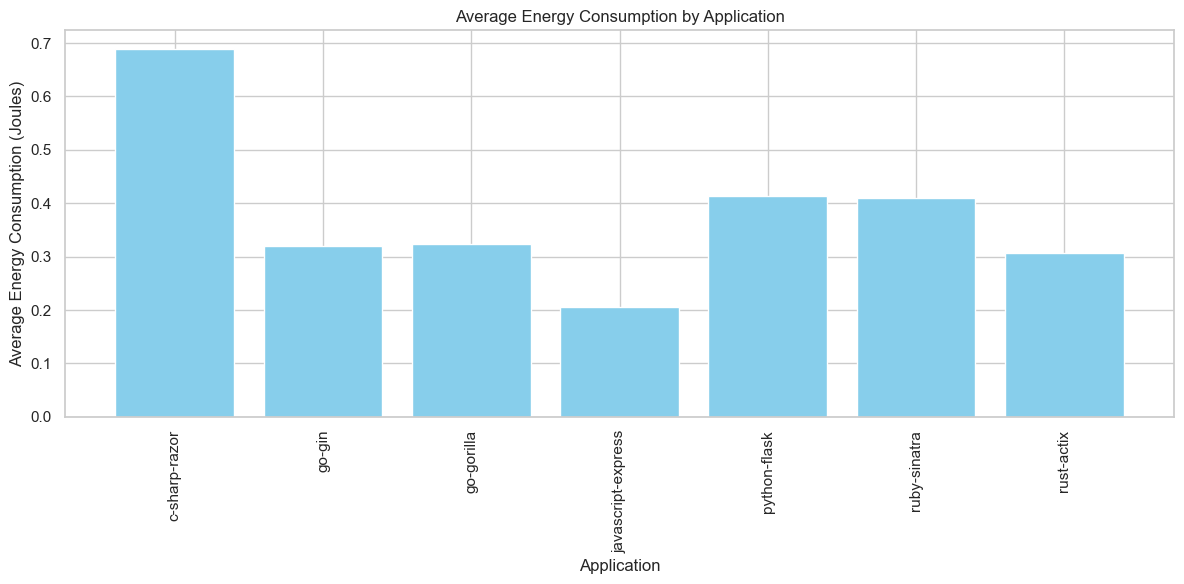

In [45]:
# Group by 'Application' and calculate the average energy consumption
avg_energy_consumption = df.groupby('application')['energy_consumption'].mean().reset_index()

# Plot the average energy consumption for each application
plt.figure(figsize=(12, 6))
plt.bar(avg_energy_consumption['application'], avg_energy_consumption['energy_consumption'], color='skyblue')
plt.xlabel('Application')
plt.ylabel('Average Energy Consumption (Joules)')
plt.title('Average Energy Consumption by Application')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

We see that `c-sharp-razor` has the highest energy consumption, while `javascript-express` has the lowest energy consumption. This already indicates that we can approve the first hypothesis that `c-sharp-razor` consumes more energy than any other web framework in the dataset, if we look at the average energy consumption.


**Digging deeper into the data**

To get a better understand of the variables in the dataset, we try visaulising it in different ways.

First, we plot runtime against energy consumption for each application:

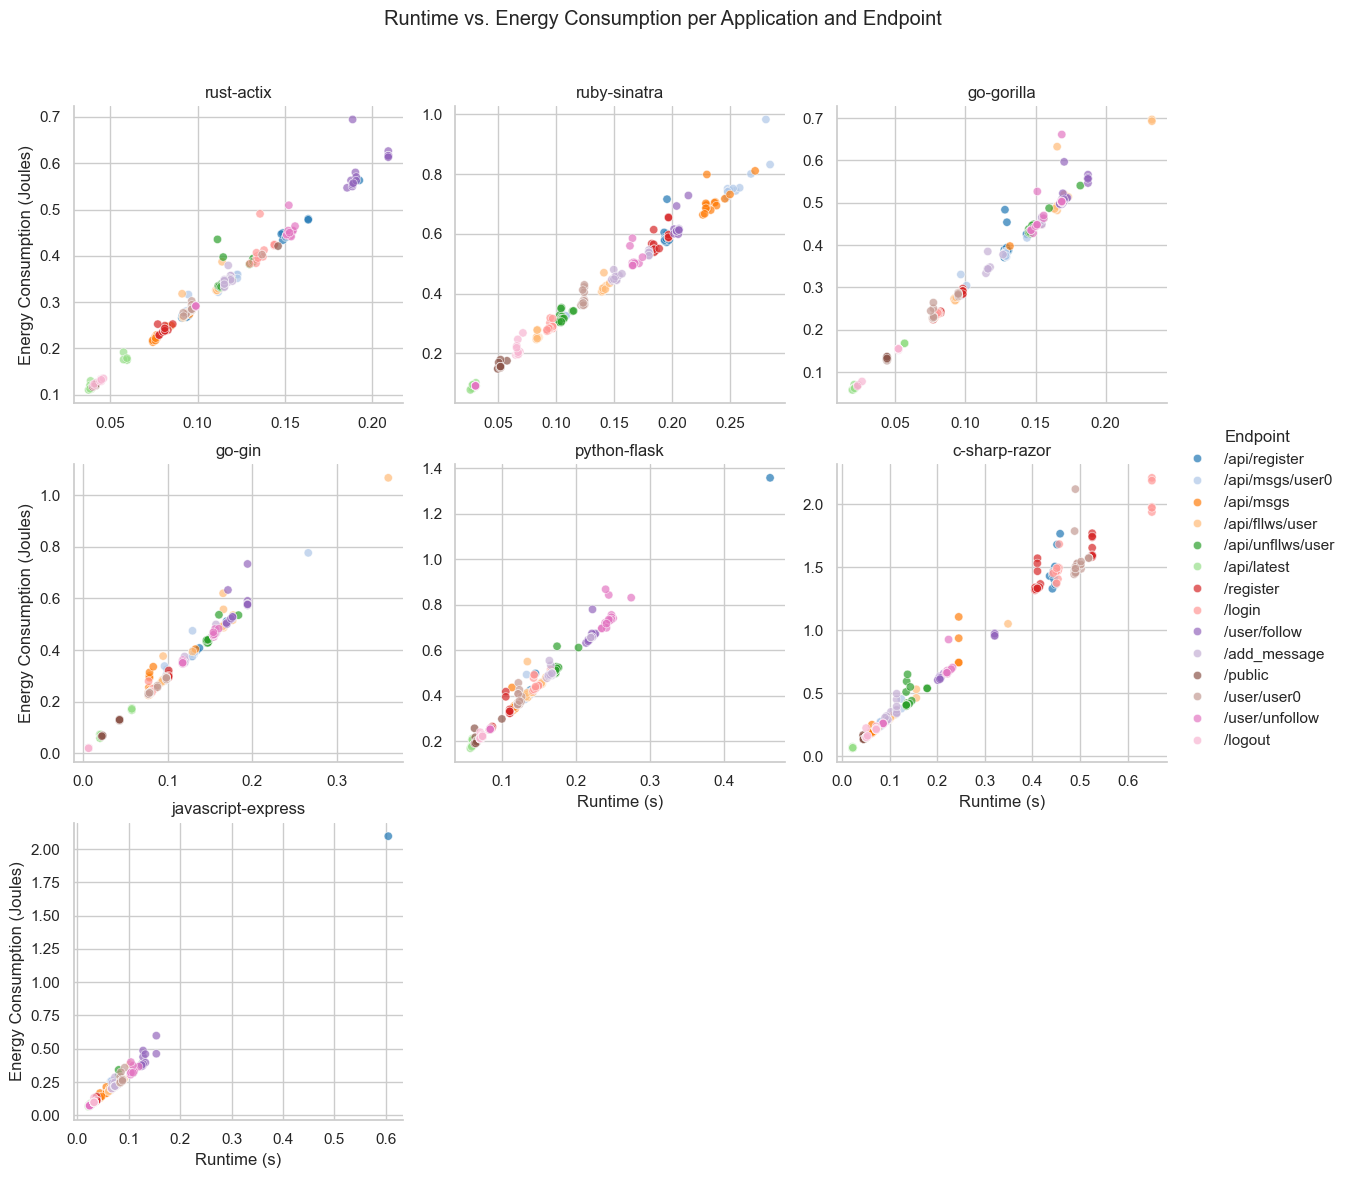

In [46]:
sns.set_theme(style="whitegrid")

# Use a more vibrant color palette
palette = sns.color_palette("tab20", n_colors=14)

# Create the FacetGrid with custom palette
g = sns.FacetGrid(df, col="application", col_wrap=3, sharex=False, sharey=False, height=4)
g.map_dataframe(sns.scatterplot, x="runtime", y="energy_consumption", hue="endpoint", palette=palette, alpha=0.7)

# Clean up the layout
g.set_axis_labels("Runtime (s)", "Energy Consumption (Joules)")
g.set_titles(col_template="{col_name}")
g.add_legend(title="Endpoint")
g.figure.subplots_adjust(top=0.9)
g.figure.suptitle("Runtime vs. Energy Consumption per Application and Endpoint")

plt.show()

An initial look makes it look like most applications have a linear relationship between energy consumption and runtime. Most applications also seem to have a low variance in energy consumption apart from `c-sharp-razor` which has a high variance with more outliers.
We can also see that the `c-sharp-razor` application has a higher energy consumption than the other applications. This is interesting because it is one of the hypotheses we want to test.

Let us now try to plot how energy consumption may vary across endpoints. We will do so by using a boxplot with the endpoints of a particular application, in this case we have chosen `c-sharp-razor`. 

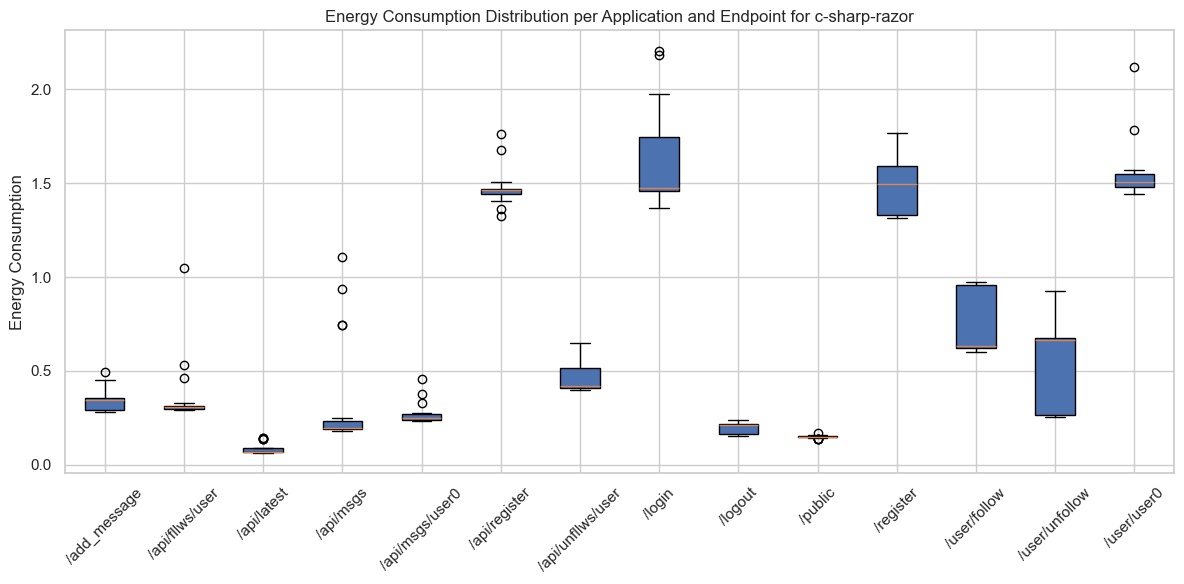

In [47]:
target = "c-sharp-razor"
# target = "javascript-express"
csharpdata = df.where(df["application"] == target)
data = csharpdata
grouped = [ group["energy_consumption"].values for _, group in data.groupby(["endpoint"]) ]
labels = data.groupby(["endpoint"]).groups.keys()

plt.figure(figsize=(12, 6))
plt.boxplot(grouped, tick_labels=labels, patch_artist=True)
plt.title(f"Energy Consumption Distribution per Application and Endpoint for {target}")
plt.ylabel("Energy Consumption")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

We see that the majority of endpoints exhibit low variability, since the middle 50% (the boxes) are quite narrow. However, some endpoints also include some rather extreme outlier measurements. For example, the endpoint `/api/msgs` includes some clear outliers that are way beyond the whiskers. 

## Data transformations

To give ourself access to the framework and simplify access to the most common variables, we will do a few data transformations:
- We will extract `language` $L$ and `framework` $F$ into separate data columns
- For the analysis we will need to work with categorical data, specfically the columns `application` $A$, `language` $L$, and `framework` $F$.
- And we will standardize `runtime` $R$ and `energy consumption` $C$, because regression models work better with variables of similar scale.

In [48]:
language, framework = list(zip(*df["application"].apply(lambda a: a.split("-") if not a.startswith("c-sharp") else [a[0:7], a[8:]])))
df["language"] = list(language)
df["L"] = df["language"]
df["framework"] = list(framework)
df["F"] = df["framework"] 

Next we will create a standadized $R_{stand}$ and $C_{stand}$ column, so high outliers will not affect the model too much. 

The formular for standardization is:
$$X_{stand} = \frac{X - median(X)}{Std(X)}$$
Where $median(X)$ is the median of $X$ and $Std(X)$ is the standard deviation of $X$.


In [49]:
df["R_stand"] = (df["runtime"] - df["runtime"].mean()) / df["runtime"].std()
df["C_stand"] = (df["energy_consumption"] - df["energy_consumption"].mean()) / df["energy_consumption"].std()

The next cell will create indexes for the categorical data columns

In [50]:
A_cats = pd.Categorical(df["application"])
L_cats = pd.Categorical(df["language"])
F_cats = pd.Categorical(df["framework"])
df["A"] = A_cats.codes
df["L"] = L_cats.codes
df["F"] = F_cats.codes
df["C"] = df["energy_consumption"]
df["R"] = df["runtime"]

print("Application code to to its category label:")
for code, label in enumerate(A_cats.categories):
    print(f"  {code}: {label}")

Application code to to its category label:
  0: c-sharp-razor
  1: go-gin
  2: go-gorilla
  3: javascript-express
  4: python-flask
  5: ruby-sinatra
  6: rust-actix


Let us take a look at the final *dataframe* with all our data transformations applied

In [51]:
df

,application,endpoint,energy_consumption,runtime,language,L,framework,F,R_stand,C_stand,A,C,R
0,rust-actix,/api/register,0.449358,0.148812,rust,5,actix,0,0.257760,0.226844,6,0.449358,0.148812
1,rust-actix,/api/register,0.433871,0.148895,rust,5,actix,0,0.258643,0.175329,6,0.433871,0.148895
2,rust-actix,/api/register,0.270844,0.094729,rust,5,actix,0,-0.317940,-0.366952,6,0.270844,0.094729
3,rust-actix,/api/register,0.479776,0.163467,rust,5,actix,0,0.413760,0.328024,6,0.479776,0.163467
4,rust-actix,/api/register,0.268833,0.092300,rust,5,actix,0,-0.343796,-0.373640,6,0.268833,0.092300
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1955,javascript-express,/logout,0.096436,0.032214,javascript,2,express,1,-0.983395,-0.947085,3,0.096436,0.032214
1956,javascript-express,/logout,0.097559,0.032214,javascript,2,express,1,-0.983395,-0.943350,3,0.097559,0.032214
1957,javascript-express,/logout,0.096922,0.032214,javascript,2,express,1,-0.983395,-0.945470,3,0.096922,0.032214
1958,javascript-express,/logout,0.097086,0.032214,javascript,2,express,1,-0.983395,-0.944924,3,0.097086,0.032214


## Testing Hypothesis 1

In this section we will test hypothesis 1, restated below:
- **H1** - The web framework `c-sharp-razor` consumes more energy than any other web framework in the dataset.

The first step will be to create a simple model with a single intercept per application ($A$).

Let's build a simple model:
$$
\begin{aligned}
    C &\sim \text{Normal}(\mu, \sigma) \\
    \mu &\sim \alpha_{[A[i]]} \\
    \alpha &\sim \text{Normal}(0,2) \\
    \sigma &\sim \text{Exponential}(1)
\end{aligned}
$$

**Why these distributions?**

The reasoning for choosing distributions for the priors is as follows. It is important to note that we have standardized the data, so if values are negative, it just means they are below the mean of the data:

- **$C \sim \text{Normal}(\mu, \sigma)$**: We are working with standardized energy consumption, so we try to fit it to a normal distribution around 0. We chose a normal dirstribution at the lack of better options with our current knowledge.     
- **$\alpha \sim \text{Normal}(0,2)$**: We do not have a good intuition about the intercepts of the different applications. Therefore, we default to a normal distribution with a mean of 0 and a standard deviation of 2. This means we expect the intercepts to be between -4 and 4 with a 95% probability. We believe that defaulting to a normal distribution is the most reasonable choice given our lack of an intuition.
- **$\mu \sim \alpha_{[A[i]]}$**: Our mean is just an intercept for each application, allowing us to keep the model as simple as possible and limiting the number of parameters.
- **$\sigma \sim \text{Exponential}(1)$**: We know that the standard deviation of the outcome variable is positive. Therefore, we choose an exponential distribution with a mean of 1. This means we expect the standard deviation to be between 0 and 3 with a 95% probability.

**Prior predictive check**

Before we start constructing any models with these priors, the first step will be checking our priors are sensible by doing a prior predictive check:

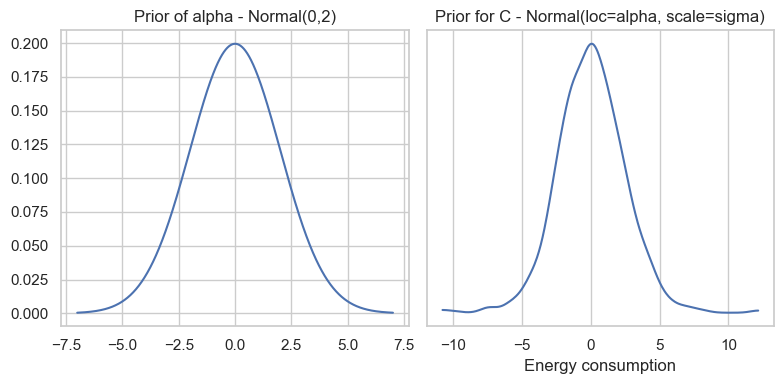

In [52]:
np.random.seed(rng)
n_samples = 1000
alpha_mean = 0
alpha_std = 2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
x = np.linspace(-7,7,n_samples)
alpha_sample = stats.norm.pdf(x, alpha_mean, alpha_std)
sigma_sample = stats.expon.pdf(x, 1)
ax1.plot(x, alpha_sample)
ax1.set_title(f"Prior of alpha - Normal({alpha_mean},{alpha_std})")

alpha_sample = stats.norm.rvs(loc=alpha_mean, scale=alpha_std, size=n_samples)
sigma_sample = stats.expon.rvs(scale=1.0, size=n_samples)
prior_c = stats.norm.rvs(loc=alpha_sample, scale=sigma_sample)

az.plot_kde(prior_c, ax=ax2)
ax2.set_xlabel("Energy consumption")
ax2.set_title(f"Prior for C - Normal(loc=alpha, scale=sigma)")
ax2.set_yticks([])

plt.tight_layout()
plt.show()

The prior for $C$ looks reasonable, since we are working with standardized energy consumption values, we expect $C$ to have a mean around 0. For $\alpha$ we are also satisfied since it allows both positive and negative values, allowing values that either push energy consumption of an application to be better (-) or worse (+) than the mean energy consumption.

Next, let us create the model using PYMC. Note that as part of the model we include a deterministic *diff* variable, which represents the contrast between each application and `c-sharp-razor`. This contrast allows us to consider the posterior distribution of differences in $\alpha$-values, enabling us to capture uncertainty when evaluating hypothesis 1. 

In [53]:
with pm.Model() as m_h1_only_intercept:
    C_data = pm.Data("C_data", df["C_stand"].values, mutable=True)
    A_data = pm.Data("A_data", df["A"].values, mutable=True)

    alpha = pm.Normal("alpha", 0, 2, shape=df["A"].unique().size)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", alpha[A_data])

    C = pm.Normal("C", mu=mu, sigma=sigma, observed=C_data)

    diff = pm.Deterministic("diff", alpha - alpha[0])

    trace_h1_only_intercept = pm.sample(random_seed=rng, idata_kwargs = { 'log_likelihood': True })

c:\Users\patr7\miniconda3\envs\prpro-2025\Lib\site-packages\pymc\data.py:440: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 40 seconds.


**Sampling**

Next, we will consider the sampling process, starting with a trace plot:

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>]], dtype=object)

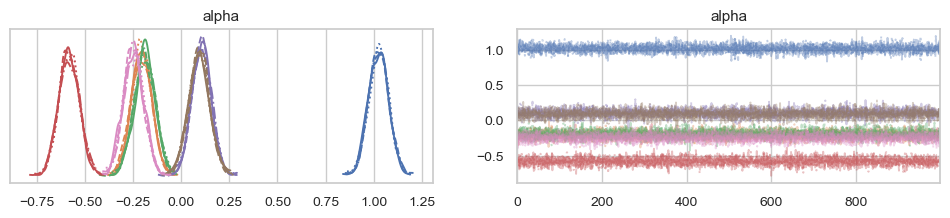

In [54]:
az.plot_trace(trace_h1_only_intercept, var_names=["alpha"])

Looking at the trace plot - the sampling process looks successful. Specfically, in the right hand side of the plot we see good mixing (read: *zig zagging*) and good convergance (chains are sticking to the same high probability areas). 

In [55]:
az.summary(trace_h1_only_intercept, var_names=["alpha", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],1.025,0.052,0.933,1.126,0.001,0.001,4961.0,3118.0,1.0
alpha[1],-0.206,0.053,-0.304,-0.109,0.001,0.001,4762.0,3246.0,1.0
alpha[2],-0.189,0.054,-0.290,-0.087,0.001,0.001,5249.0,3154.0,1.0
alpha[3],-0.581,0.053,-0.683,-0.485,0.001,0.000,5848.0,3018.0,1.0
alpha[4],0.106,0.051,0.015,0.207,0.001,0.001,4456.0,3347.0,1.0
alpha[5],0.093,0.054,-0.009,0.198,0.001,0.001,4906.0,3218.0,1.0
alpha[6],-0.247,0.052,-0.348,-0.155,0.001,0.001,5140.0,2952.0,1.0
sigma,0.884,0.014,0.855,0.909,0.000,0.000,5119.0,2738.0,1.0


Looking at the summary of the simulation, firstly we see that the $\hat r$ values are all 1, again suggesting that the sampling process was successful. This is further supported by a high effective sample size (ess_bulk), we are sampling 1000 samples over 4 chains, so drawing 4000 samples. 

Interestingly, considering only the $\alpha$ parameters, we see that the mean $\alpha$ is highest for the application with index 0 (`c-sharp-razor`), and the model is fairly confident (low standard deviation).

**What do the results describe?**

The results discribe the likelihood of the intercept parameters for each application taking on specific values. For example, we see that the inctercept parameter for `c-sharp-razor` is likely to have a value around $1.024$. Another way of describing the result is to say that we have modelled out confidence that the intercept parameter for `c-sharp-razor` is in the span $0.9$ to $1.1$ with 97% probability (Becuase the Highest Density Interval (HDI) describes the region where the PDF of the parameter has 97% of its density).

Similarly, we see our confidence of the sigma paramter is quite high to be in the range of $0.856$ to $0.910$.

Next, let us plot the contrasts ($\alpha - \alpha_{\text{c-sharp-razor}}$):

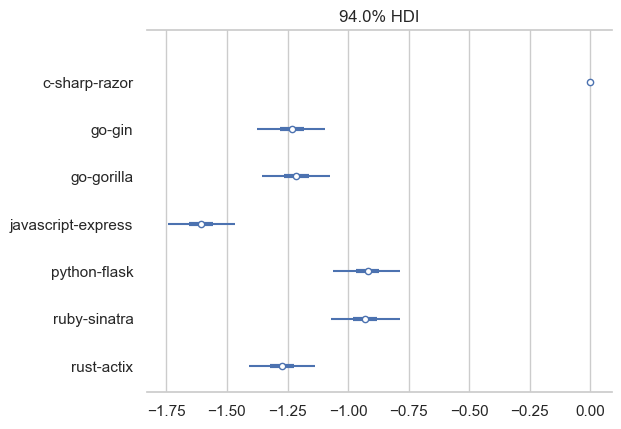

In [56]:
ax = az.plot_forest(trace_h1_only_intercept, var_names=["diff"], combined=True)
ax[0].set_yticklabels( reversed(A_cats.categories) )
plt.show()

Since we are comparing to `c-sharp-razor`, we see that the contrast for `c-sharp-razor` is 0, as expected. The other contrasts are all negative and does not overlap with 0, meaning thye must be lower than `c-sharp-razor`. This is a strong indication that hypothesis 1 holds, since we see that the energy consumption of `c-sharp-razor` is higher than all the other applications.

But before drawing any conclusions, we should do some model checking in the form a posterior predictive check.

**Posterior predictive check**

The goal of the posterior predictive check is to validate whether our model *works*. We want to know that the model captures the structure of the observed data. We first sample the posterior distribution of model parameters then simulate new data (*retrodictions*) using these sampled parameter values, and lastly we compare the simulated data with the original. For the posterior predictive check to be a success the simulated data should (with some error) match the original.

We first sample the posterior using PYMC:

In [57]:
with m_h1_only_intercept:
    pm.sample_posterior_predictive(trace_h1_only_intercept, extend_inferencedata=True, random_seed=rng)

Sampling: [C]


Output()

Next, we simulate using our parameters sampled from the posterior and visualise them alongside the observed data: 

array([<Axes: xlabel='C'>], dtype=object)

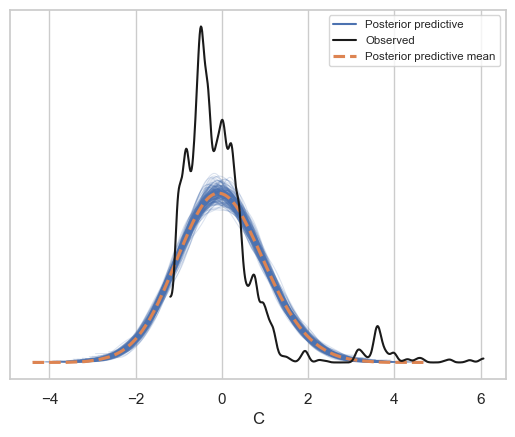

In [58]:
_, ax = plt.subplots()
az.plot_ppc(trace_h1_only_intercept, num_pp_samples = 200, ax=ax)

In the plot above the blue lines are the distributions generated from the sampled parameters (the simulated data) and the black is the observed data. 

Looking at the plot, we observe the the posterior predictive distribution is skewed relative to the observed distribution. The mean of distribution sits slightly to the right of observed data. Addtionally, the shape of the posterior distribution is wider than the observed, the model overestimates the variance. Both of these observations are likely due to the $\text{Normal}$-distribution's sensitivity to outliers.

From a software developer's perspective it makes sense that outliers are rare but not impossible. There are many factors like garbage collection, Just-In-Time compilation, operating system interupts, etc. that may produce such outliers. If we want a model to work in such a domain, we should make it robust to outliers. To achieve for this, we replace the $\text{Normal}$ distribution likelihood with a $\text{Student}$'s t-distribution, which is more robust to outliers due to its heavy tails.

### Improving the model



Using these observations lets build another model:
$$

\begin{aligned}
    C &\sim \text{StudentT}(\mu, \sigma) \\
    \mu &\sim \alpha_{[A[i]]} \\
    \alpha &\sim \text{Normal}(0,1) \\
    \sigma &\sim \text{Exponential}(1)
\end{aligned}

$$



As before, we will do a prior predictive check in order to verify that $\alpha, \sigma$, and our choice of $\text{Student}$'s t-distribution lead to a satisfactory likelihood for $C$. 

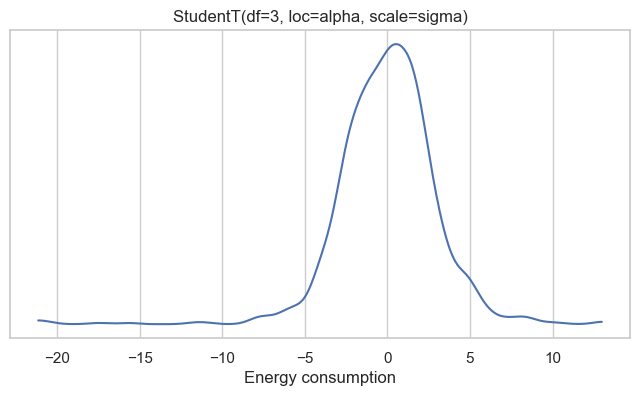

In [59]:
np.random.seed(rng)
fig, (ax2) = plt.subplots(1, 1, figsize=(8, 4))

alpha_sample = stats.norm.rvs(loc=alpha_mean, scale=alpha_std, size=n_samples)
sigma_sample = stats.expon.rvs(scale=1.0, size=n_samples)
prior_c = stats.t.rvs(df=3, loc=alpha_sample, scale=sigma_sample)

az.plot_kde(prior_c, ax=ax2)
ax2.set_xlabel("Energy consumption")
ax2.set_title(f"StudentT(df={3}, loc=alpha, scale=sigma)")
ax2.set_yticks([])
plt.show()

The new likelihood for $C$ encapsulates our domain knowledge that outliers are plausible, making it less sensitive to outliers.

TODO: Could use a better description 

We are now able to implement the model using PYMC:

In [60]:
with pm.Model() as m_h1_studentT:
    C_data = pm.Data("C_data", df["C_stand"].values, mutable=True)
    A_data = pm.Data("A_data", df["A"].values, mutable=True)

    alpha = pm.Normal("alpha", 0, 2, shape=df["A"].unique().size)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", alpha[A_data])

    C = pm.StudentT("C", nu=3, mu=mu, sigma=sigma, observed=C_data)

    diff = pm.Deterministic("diff", alpha - alpha[0])

    trace_h1_studentT = pm.sample(random_seed=rng, idata_kwargs = { 'log_likelihood': True })

c:\Users\patr7\miniconda3\envs\prpro-2025\Lib\site-packages\pymc\data.py:440: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.


As with the previous model, we have included a contrast between every application and `c-sharp-razor` as a variable inside of the model, we shall use this later for the hypothesis testing.

**Sampling**

Let us consider the sampling process by first plotting the trace:

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

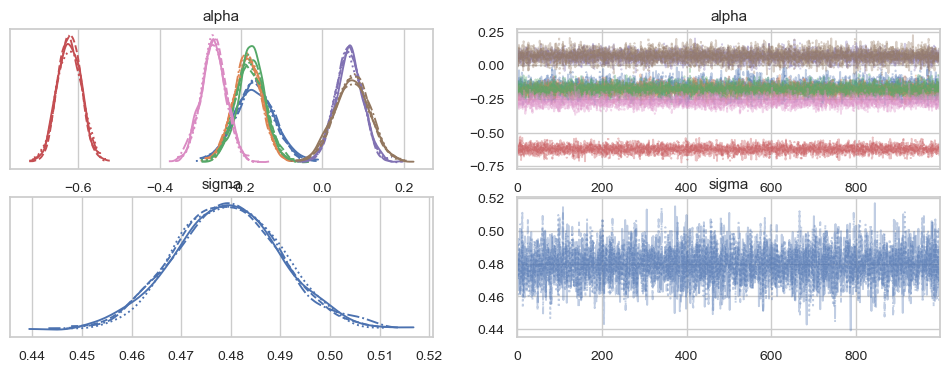

In [61]:
az.plot_trace(trace_h1_studentT, var_names=["alpha", "sigma"])

The sampling trace looks good. We see solid *mixing* in the right hand side plot, where the lines are zig-zagging whilst consistently exploring the same high probability areas (good *stationarity*). Shifting our attention to the left plot, we see that the independent chains converging to similar distributions. The different line styles (e.g. solid, dashed) represent separate MCMC chains and the overlap indicates good convergence.

Next, we will consider the $\hat r$ and effective-sample size.

In [62]:
az.summary(trace_h1_studentT, var_names=["alpha", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-0.166,0.048,-0.255,-0.076,0.001,0.0,4552.0,2999.0,1.0
alpha[1],-0.183,0.035,-0.249,-0.120,0.000,0.0,5533.0,3267.0,1.0
alpha[2],-0.176,0.036,-0.246,-0.113,0.000,0.0,5252.0,3253.0,1.0
alpha[3],-0.622,0.029,-0.675,-0.565,0.000,0.0,5740.0,3177.0,1.0
alpha[4],0.065,0.034,0.004,0.130,0.000,0.0,5356.0,3600.0,1.0
alpha[5],0.073,0.044,-0.015,0.148,0.001,0.0,4186.0,3252.0,1.0
alpha[6],-0.267,0.031,-0.327,-0.210,0.000,0.0,6096.0,3191.0,1.0
sigma,0.479,0.011,0.460,0.500,0.000,0.0,4932.0,3772.0,1.0


The $\hat r$ (of all ones) and a large effective sample size (`ess_bulk`) also support the claim that the sampling process was successful.

**Posterior predictive check**

The previous model fell a little short at the model checking step. Before continuing we shall do a posterior predictive check of this new model. The procedure is exactly the same, first we sample the posterior, then we simulate data, and lastly we compare the simulated to the observed data.

Below we sample parameters from the posterior distribtuion using PYMC.

In [63]:
with m_h1_studentT: 
    pm.sample_posterior_predictive(trace_h1_studentT, extend_inferencedata=True, random_seed=rng)

Sampling: [C]


Output()

Using our sampled parameters we simulate new data and plot them alongside the original observed data used to fit the model

array([<Axes: xlabel='C'>], dtype=object)

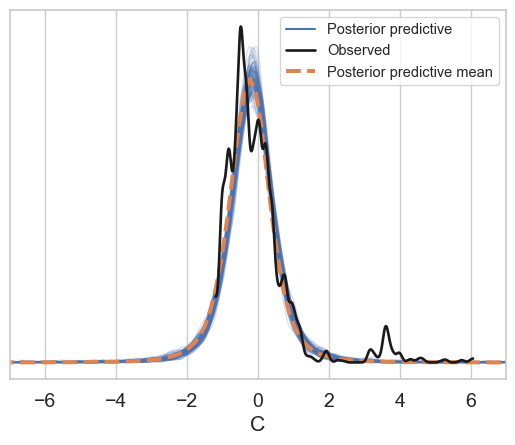

In [64]:
fig, ax = plt.subplots()
ax.set_xlim(-7,7)
az.plot_ppc(trace_h1_studentT, num_pp_samples=100, figsize=(10, 5), random_seed=rng, ax = ax)

From the plot above, we observe that the posterior distribution of the new model - with a Student's t likelihood - closely recreates the observed data. Compared to the previous model - with a $\text{Normal}$ likelihood - the mean is much closer to that of the observed distribution and the outliers have not "pulled" the posterior probability distribution, there is no longer a visible "skew". These improvements increase our confidence that the model works correctly.

Now, we have verified our priors and done a posterior predictive check, we are ready to take a look at the contrasts.

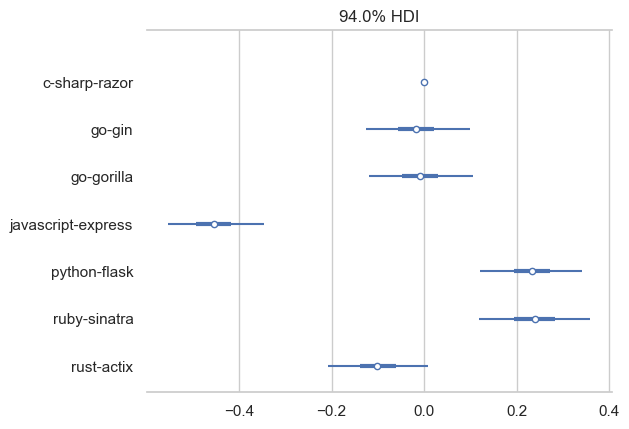

In [65]:
ax = az.plot_forest(trace_h1_studentT, var_names=["diff"], combined=True)
ax[0].set_yticklabels( reversed(A_cats.categories) )
plt.show()

Interestingly, `c-sharp-razor` now sits somewhere in the middle. There are even applications such as `ruby-sinatra` and `python-flask` that consume more energy. This is a very different view from that of the first model where `c-sharp-razor` was the worst the performing. This may also suggest that `c-sharp-razor` is the most prone to produce outliers, which is not entirely unimaginable given it is a garbage-collected and JIT compiled language, so we expect that some number of requests is required before such applications run at their best.  

### Conditioning on runtime

This touches upon an interesting aspect, namely that garbage-collection, JIT etc. influence runtime but does that also influence the energy consumption? Let us build a model that is conditioned on runtime in order to better understand this relation and if it has any impact on our conclusion of H1 so far.

Since runtime is a continous variable we include it as a slope and just extend the model. Furthermore, since we are working with standardised energy consumption and we would expect 0 runtime (no running) to result in 0 energy consumption, we will model a shared intercept $\alpha$ and instead let each application have its own slope $\beta$. 

This results in the following model:
$$
\begin{aligned}
    C &\sim \text{StudentT}(\mu, \sigma) \\
    \mu &\sim \alpha_{} + \beta_{A[i]}*R \\
    \beta &\sim \text{Normal}(0,1) \\
    \alpha &\sim \text{Normal}(0,1) \\
    \sigma &\sim \text{Exponential}(1)
\end{aligned}
$$

Before actually building the model with PYMC, let us make sure the priors are reasonable by doing a *prior predictive check*.

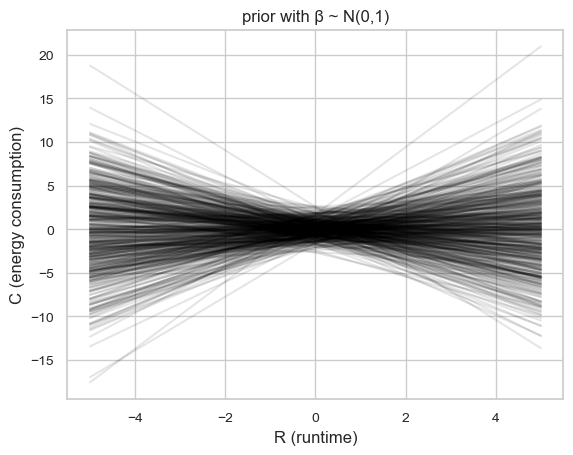

In [66]:
np.random.seed(rng)

n_samples = 500
x = np.linspace(-5, 5, n_samples)

beta_sample = stats.norm.rvs(loc=0, scale=1, size=n_samples)
alpha_sample = stats.norm.rvs(loc=0, scale=1, size=n_samples)
sigma_sample = stats.expon.rvs(scale=1.0, size=n_samples)

for a,b in zip(alpha_sample, beta_sample):
    values = a + b * x
    plt.plot(x, values, color="black", alpha=0.1)

plt.title('prior with β ~ N(0,1)', fontsize='medium')
plt.xlabel('R (runtime)', fontsize='medium')
plt.ylabel('C (energy consumption)', fontsize='medium')
plt.tick_params(axis='both', labelsize='small')
plt.show()

Using these priors we allow negative slopes, that seems very unreasonable! It is quite difficult to imagine that increased running time means less energy consumed. This has to be fixed before proceeding, we need a distribution that enables us to encode (bias) that negative slopes are impossible. One such distribution could be the $\text{LogNormal}$ distribution, let's try $\beta \sim \text{LogNormal}(0,0.5)$.

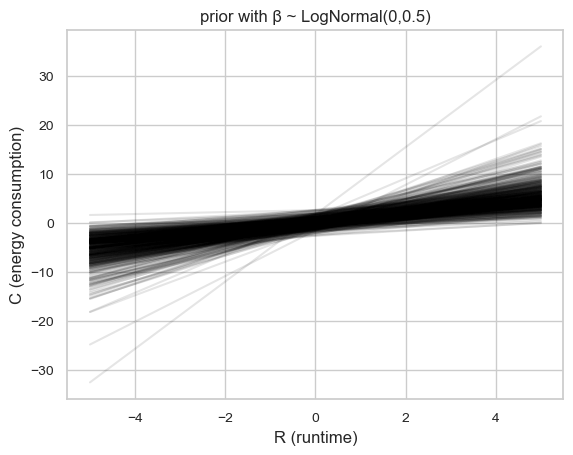

In [67]:
np.random.seed(rng)
beta_sample = stats.lognorm.rvs(s=0.5, scale=np.exp(0.0), size=n_samples)
alpha_sample = stats.norm.rvs(loc=0, scale=1, size=n_samples)
sigma_sample = stats.expon.rvs(scale=1.0, size=n_samples)
for a,b in zip(alpha_sample, beta_sample):
    values = a + b * x
    plt.plot(x, values, color="black", alpha=0.1)

plt.title('prior with β ~ LogNormal(0,0.5)', fontsize='medium')
plt.xlabel('R (runtime)', fontsize='medium')
plt.ylabel('C (energy consumption)', fontsize='medium')
plt.tick_params(axis='both', labelsize='small')
plt.show()

This immediately looks much more reasonable! By excluding negative slopes, we ensure that the model cannot produce scenarios where increased running time leads to a smaller energy consumption. This matches our domain knowledge that running longer means more energy consumed.

Let's finally build the model with the new prior for $\beta$ using PYMC:

$$
\begin{aligned}
    C &\sim \text{StudentT}(\mu, \sigma) \\
    \mu &\sim \alpha_{} + \beta_{A[i]}*R \\
    \beta &\sim \text{LogNormal}(0,0.5) \\
    \alpha &\sim \text{Normal}(0,1) \\
    \sigma &\sim \text{Exponential}(1)
\end{aligned}
$$

In [68]:
with pm.Model() as m_h1_with_runningtime:
    C_data = pm.Data("C_data", df["C_stand"].values, mutable=True)
    A_data = pm.Data("A_data", df["A"].values, mutable=True)
    R_data = pm.Data("R_data", df["R_stand"].values, mutable=True)

    beta  = pm.LogNormal("beta", 0,0.5, shape=df["A"].unique().size)
    alpha = pm.Normal("alpha", 0,1)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", alpha + beta[A_data] * R_data)
    C = pm.StudentT("C", nu=3, mu=mu, sigma=sigma, observed=C_data)

    diff = pm.Deterministic("diff", beta - beta[0])

    trace_h1_with_runningtime = pm.sample(random_seed=rng, idata_kwargs = { 'log_likelihood': True })

c:\Users\patr7\miniconda3\envs\prpro-2025\Lib\site-packages\pymc\data.py:440: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.


As with the previous two models we have inlcuded a *diff* variable to be the contrast between the effect of runtime on each application with `c-sharp-razor`. Additionally, the model now includes a new variable $\beta$ with seven values (number of distinct applications), and the $\alpha$ variable has been reduced to a scalar. 

**Consider sampling**

Let us once again make sure the sampling process was successful by first plotting the trace.

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

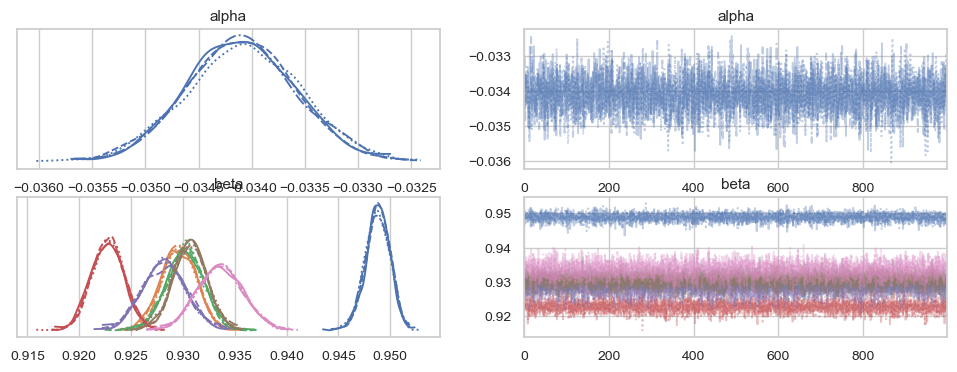

In [69]:
az.plot_trace(trace_h1_with_runningtime, var_names=["alpha", "beta"])

Looking at the trace plot, the sampling process looks to have been succesful. We see good stationarity, convergence, and mixing for both $\alpha$ and $\beta$. Particularly in the trace of alpha (upper right corner) notice that the scale of the y-axis is very small, so do not be mislead. 

Next, let us again exaimine the $\hat r$ values and effective sample size.

In [70]:
az.summary(trace_h1_with_runningtime, var_names=["alpha", "beta"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.034,0.001,-0.035,-0.033,0.0,0.0,4123.0,3448.0,1.0
beta[0],0.949,0.001,0.947,0.951,0.0,0.0,5132.0,3097.0,1.0
beta[1],0.930,0.002,0.926,0.933,0.0,0.0,4174.0,3310.0,1.0
beta[2],0.930,0.002,0.927,0.933,0.0,0.0,5101.0,3356.0,1.0
beta[3],0.923,0.002,0.920,0.926,0.0,0.0,4420.0,3389.0,1.0
beta[4],0.928,0.002,0.924,0.932,0.0,0.0,4923.0,3119.0,1.0
beta[5],0.931,0.002,0.928,0.934,0.0,0.0,5659.0,2943.0,1.0
beta[6],0.934,0.002,0.930,0.938,0.0,0.0,4686.0,3149.0,1.0


All the $\hat r$ values are 1, indicating a succesful sampling process. Additionally, the effective sample size as seen by the `ess_bulk` is large considering we are sampling 1000 draws over four MCMC chains ($1000\times 4 = 4000$ samples drawn in total). 

Before drawing any conclusions let us again do a posterior predictive check of this new model conditioned on runtime.

**Posterior predictive check**

First we sample parameter values from the posterior:

In [71]:
with m_h1_with_runningtime:
    pm.sample_posterior_predictive(trace_h1_with_runningtime, extend_inferencedata=True, random_seed=rng)

Sampling: [C]


Output()

Next, we simulate new data and plot it against the observed.

array([<Axes: xlabel='C'>], dtype=object)

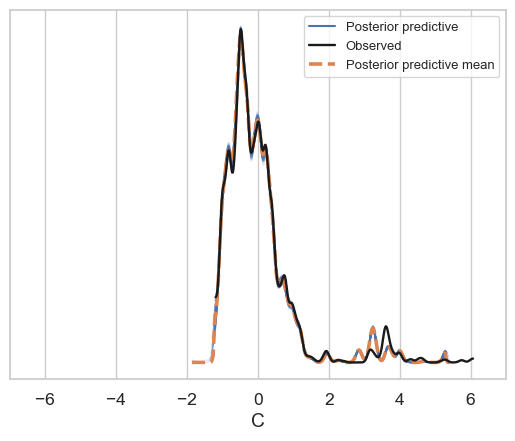

In [72]:
fig, ax = plt.subplots()
ax.set_xlim(-7,7)
az.plot_ppc(trace_h1_with_runningtime, num_pp_samples=100, figsize=(8, 5), random_seed=rng, ax = ax)

The plot above is worrying - it appears the model has worked "too" well, to the point of overfitting. There are many indicators of overfitting but most notable is that the model is recreating outliers from the observed data. This model has become an expert in the small world (as McElreath calls it) and we cannot use it to answer hypothesis 1 which is defined in the big world.

**TODO: Motivate why comparing is fun**

In [73]:
az.compare({'Normal':trace_h1_only_intercept, 'StudentT':trace_h1_studentT, 'with runningtime': trace_h1_with_runningtime}, ic='waic')

c:\Users\patr7\miniconda3\envs\prpro-2025\Lib\site-packages\arviz\stats\stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
with runningtime,0,3511.345055,8.401799,0.000000,0.946007,117.214521,0.000000,False,log
StudentT,1,-2147.636054,9.229456,5658.981109,0.017809,58.843087,100.926538,False,log
Normal,2,-2544.676559,10.444923,6056.021614,0.036184,60.330567,103.921687,True,log


**TODO: What do theese results tell us?**

We see that the model using a lognormal likelihood has a better predictive capability. 
- elpd_waic is higher (because we are not on deviance scale). 
- p_waic (effective parameters) is also lower 
- weight = bigger

## Conclusion on H1

As the third and final model we built was of little help due to overfitting, we must base our conclusion on model two - with an intercept for each application and Student's t likelihood. Let us recreate the plot: 


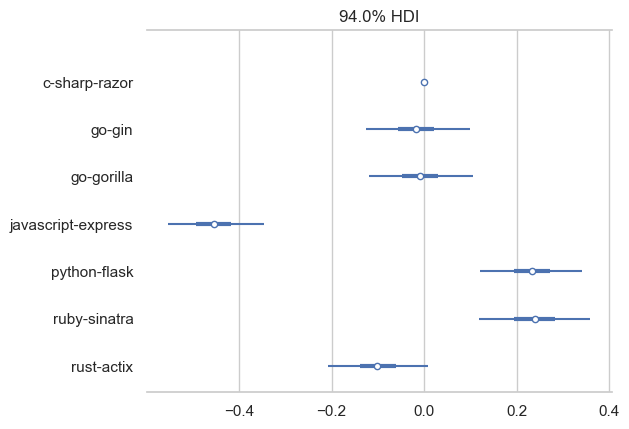

In [74]:
ax = az.plot_forest(trace_h1_studentT, combined=True, var_names=["diff"])
ax[0].set_yticklabels( reversed(A_cats.categories) )
plt.show()

From the plot above we that applications `ruby-sinatra` and `python-flask`, show clear evidence of higher energy-consumption than `c-sharp-razor`. The posterior constrasts do not include 0 in their HDI, suggesting that the difference between these and `c-sharp` is non-zero and in fact greater than 0.

This means that we are able to reject hypothesis 1, which stated that `c-sharp-razor` consumed more energy than other frameworks in the dataset.

Addtionally, other frameworks like `go-gin` and `go-gorilla` have posterior contrasts that include 0 in the HDI. Meaning, we cannot confidently determine whether these also perform worse, better or the same as `c-sharp-razor`. 

----

## If time permits?

What would we have done if we had a little more time?

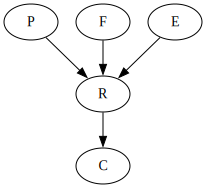

In [75]:
from causalgraphicalmodels import CausalGraphicalModel

potential1 = CausalGraphicalModel(["P", "F", "R","C", "E"], [("P", "R"), ("F", "R"), ("R", "C"), ("E", "R")])
potential1.draw()


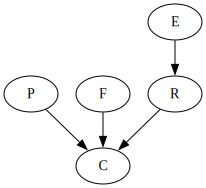

In [76]:
potential2 = CausalGraphicalModel(["P", "F", "R","C", "E"], [("R","C"), ("E","R"), ("F","C"), ("P", "C")])
potential2.draw()

In [106]:
with pm.Model() as m_h1_hierarchical:
    C_data = pm.Data("C_data", df["C_stand"].values, mutable=True)
    A_data = pm.Data("A_data", df["A"].values, mutable=True)
    R_data = pm.Data("R_data", df["R_stand"].values, mutable=True)

    # Shared intercept
    alpha = pm.Normal("alpha", mu=0, sigma=1)

    # Hyperpriors for group-level slope variation
    mu_beta = pm.Normal("mu_beta", mu=0, sigma=0.5)
    sigma_beta = pm.Exponential("sigma_beta", 1.0)

    # Hierarchical slope per group
    beta = pm.Normal("beta", mu=mu_beta, sigma=sigma_beta, shape=df["A"].nunique())

    # Noise
    sigma = pm.Exponential("sigma", 1.0)

    # (Optional) estimate nu for Student-T if you suspect heavy tails
    nu = pm.Exponential("nu", 1/15)  # prior on degrees of freedom, favoring heavier tails

    # Linear model
    mu = pm.Deterministic("mu", alpha + beta[A_data] * R_data)

    # Likelihood
    C = pm.StudentT("C", nu=nu, mu=mu, sigma=sigma, observed=C_data)

    # Difference for post-analysis
    diff = pm.Deterministic("diff", beta - beta[0])

    # Sampling
    trace_hier = pm.sample(random_seed=rng, idata_kwargs={'log_likelihood': True})


c:\Users\patr7\miniconda3\envs\prpro-2025\Lib\site-packages\pymc\data.py:440: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, mu_beta, sigma_beta, beta, sigma, nu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 109 seconds.


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'mu_beta'}>,
        <Axes: title={'center': 'mu_beta'}>],
       [<Axes: title={'center': 'sigma_beta'}>,
        <Axes: title={'center': 'sigma_beta'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

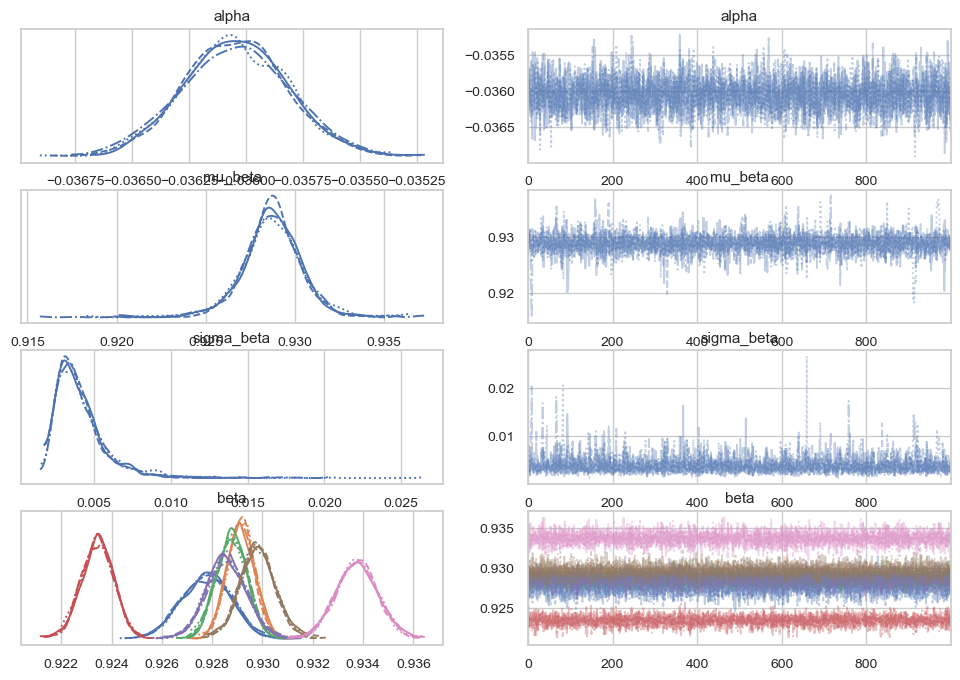

In [107]:
az.plot_trace(trace_hier, var_names=["alpha", "mu_beta", "sigma_beta", "beta"])

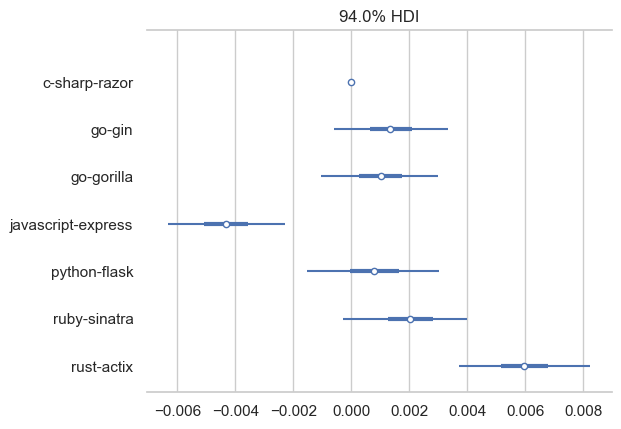

In [108]:
ax = az.plot_forest(trace_hier, combined=True, var_names=["diff"])
ax[0].set_yticklabels( reversed(A_cats.categories) )
plt.show()

In [109]:
with m_h1_hierarchical:
    pm.sample_posterior_predictive(trace_hier, extend_inferencedata=True, random_seed=rng)

Sampling: [C]


Output()

array([<Axes: xlabel='C'>], dtype=object)

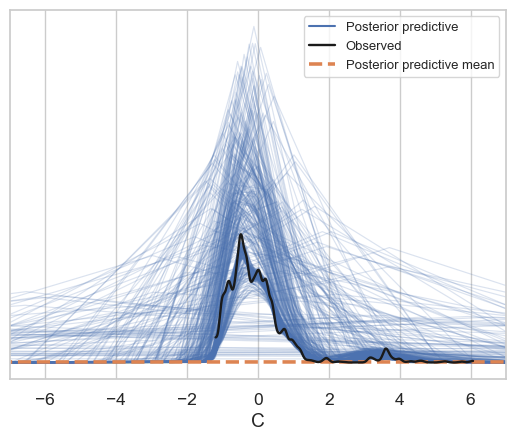

In [110]:
fig, ax = plt.subplots()
ax.set_xlim(-7,7)
az.plot_ppc(trace_hier, num_pp_samples=400, figsize=(8, 5), random_seed=rng, ax = ax)

array([<Axes: xlabel='C'>], dtype=object)

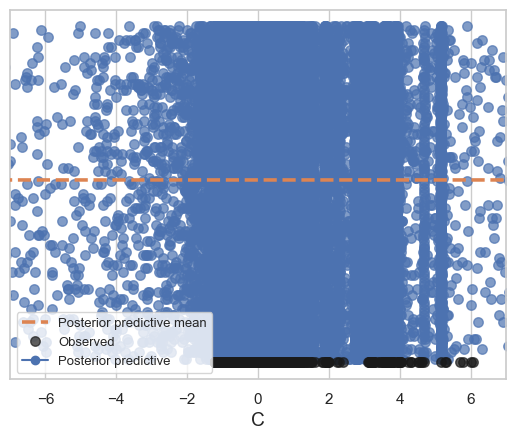

In [111]:
fig, ax = plt.subplots()
ax.set_xlim(-7,7)
az.plot_ppc(trace_hier, num_pp_samples=100, figsize=(8, 5), random_seed=rng, ax = ax, kind='scatter')

In [112]:
az.compare({'Normal':trace_h1_only_intercept, 'StudentT':trace_h1_studentT, 'with runningtime': trace_h1_with_runningtime, 'hier': trace_hier}, ic='waic')

c:\Users\patr7\miniconda3\envs\prpro-2025\Lib\site-packages\arviz\stats\stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\Users\patr7\miniconda3\envs\prpro-2025\Lib\site-packages\arviz\stats\stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
hier,0,4119.220224,8.905854,0.000000,8.148913e-01,91.578826,0.000000,True,log
with runningtime,1,3511.345055,8.401799,607.875168,1.851087e-01,117.214521,52.964275,False,log
StudentT,2,-2147.636054,9.229456,6266.856277,1.195815e-09,58.843087,81.608697,False,log
Normal,3,-2544.676559,10.444923,6663.896783,0.000000e+00,60.330567,86.493204,True,log


In [113]:
az.waic(trace_hier)

c:\Users\patr7\miniconda3\envs\prpro-2025\Lib\site-packages\arviz\stats\stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 1960 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  4119.22    91.58
p_waic        8.91        -

There has been a warning during the calculation. Please check the results.